# Toxic Comment Classification Challenge - Transfer Learning



Short Link for starter notebook: **tiny.cc/mlcc-toxic-starter-colab**

Kaggle challenge: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge


>[Toxic Comment Classification Challenge - Transfer Learning](#scrollTo=SXgAs6uoQ_Zv)

>>[Import libraries and the dataset](#scrollTo=pdQHcSnWdM4b)

>>[Extract features and labels from data input](#scrollTo=rkGUNgjocwKi)

>>[Clean Text Data](#scrollTo=FzKOcML9EP2M)

>>[Train/Validation Split](#scrollTo=qaUp1VaFek9e)

>>[Build the Model](#scrollTo=T-g85ykdp9fZ)

>>[Explore model/training variations](#scrollTo=xR39EpLBE3Jx)

>>>[Base Model](#scrollTo=iJARBviJGgBr)

>>>[Add Weight Regularization (L2)](#scrollTo=42Vmn8bxHarV)

>>>[Add Dropout](#scrollTo=mk0HY6GuIVqm)

>>[Plot the training and validation loss](#scrollTo=m1dcJG-zJA-L)

>[Test Set evaluation](#scrollTo=jTgZIPJEDAjf)

>>[References](#scrollTo=7C1075_ce57W)



## Import libraries and the dataset

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

import pandas as pd

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TensorFlow 2.x selected.
Version:  2.0.0
Eager mode:  True
Hub version:  0.6.0
GPU is available


In [0]:
# Original data belongs to https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data
! wget https://www.dropbox.com/s/ggl9krhh6dcwhhz/train.csv

--2019-10-22 02:37:03--  https://www.dropbox.com/s/ggl9krhh6dcwhhz/train.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.1, 2620:100:601f:1::a27d:901
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ggl9krhh6dcwhhz/train.csv [following]
--2019-10-22 02:37:04--  https://www.dropbox.com/s/raw/ggl9krhh6dcwhhz/train.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc71802054f6fe32550ded7da738.dl.dropboxusercontent.com/cd/0/inline/Aq7bhcQanABHa7lvbD1zZ52d14nDiLJ2gXZJfn6NeP7Ck4b3tWUsS2CTP6PVqGLsK6loPjUH7xMGrWUMRDIyFblrMCM3Z9g05uMx_KwpUYGxcA/file# [following]
--2019-10-22 02:37:04--  https://uc71802054f6fe32550ded7da738.dl.dropboxusercontent.com/cd/0/inline/Aq7bhcQanABHa7lvbD1zZ52d14nDiLJ2gXZJfn6NeP7Ck4b3tWUsS2CTP6PVqGLsK6loPjUH7xMGrWUMRDIyFblrMCM3Z9g05uMx_KwpUYGxcA/file
Resolving uc71802054f6fe3255

In [0]:
data = pd.read_csv("train.csv")
  

## Extract features and labels from data input

Split the data into Features, Labels.

Input: "comment_text"

Label: "toxic"

In [0]:
# This is a pandas DataFrame.  
dataset = data[ ["comment_text", "toxic"] ]

In [0]:
# Shape of dataset array. It contains two Pandas Series:  Features (comment_text) and Labels (toxic)
print(dataset.shape)

(159571, 2)


In [0]:
# Print the first 10 entries in the dataset
print(dataset['comment_text'].values[:5])
print(dataset['toxic'].values[:5])

["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"
 "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"
 "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info."
 '"\nMore\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on refe

## Clean Text Data

Our input text needs to be cleaned (normilized) before we start training. Our text contains a number of unnecessary characters, white spaces, punctuation, URLs, and unnecessary words that could add noise during training. 

We'll use the nltk library to help in the pre-processing. Cleaning the text consists of:
- removing URLs
- replacing punctuation and special characters with whitespace
- normilizing text to lowercase
- removing unnecesary words (stopwords).  Words which have little or no significance especially when constructing meaningful features from text are known as stopwords or stop words. These are usually words that end up having the maximum frequency if you do a simple term or word frequency in a corpus





In [0]:
import re
import string
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
#------------------------------->
# Create a function to normilize our text and Vectorize the function to apply on entire text corpus
#------------------------------->
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # remove any URLs
    doc = re.sub(r"http\S+", "", doc)
    # replace punctuation with space and remove special characters\whitespaces
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #map punctuation to space
    doc = doc.translate(translator)
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [0]:
#------------------------>
# Normalize all our "comment_text" (this is a Pandas series)
# The function returns a new vector of the normilized entire text corpus
#------------------------>
pd.options.mode.chained_assignment = None
norm_corpus = normalize_corpus(dataset['comment_text'])
dataset['comment_text'] = norm_corpus

In [0]:
# check normilize dataset
print(dataset['comment_text'].values[:5])

['explanation edits made username hardcore metallica fan reverted vandalisms closure gas voted new york dolls fac please remove template talk page since retired'
 'aww matches background colour seemingly stuck thanks talk january utc'
 'hey man really trying edit war guy constantly removing relevant information talking edits instead talk page seems care formatting actual info'
 'make real suggestions improvement wondered section statistics later subsection types accidents think references may need tidying exact format ie date format etc later one else first preferences formatting style references want please let know appears backlog articles review guess may delay reviewer turns listed relevant form eg wikipedia good article nominations transport'
 'sir hero chance remember page']


## Train/Validation Split

Split the set (80/20) Training/Validation

In [0]:
# Train / Validation data split
dataset = dataset.sample(frac=1)
train_dataset = dataset.head(int(0.8 * len(dataset)))
validation_dataset = dataset.tail(int(0.2 * len(dataset)))

In [0]:
#-------------------->
# Build TensorFlow vectors from Pandas Frame Series
#-------------------->
t_dataset = tf.data.Dataset.from_tensor_slices((train_dataset['comment_text'], train_dataset['toxic']))
v_dataset = tf.data.Dataset.from_tensor_slices((validation_dataset['comment_text'], validation_dataset['toxic']))

In [0]:
train_examples_batch, train_labels_batch = next(iter(t_dataset.batch(10)))

In [0]:
print(train_examples_batch[:5])
print(train_labels_batch[:5])

tf.Tensor(
[b'seems shot stalin'
 b'two criteria play first bear final fantasy title form region covers got second first apply feature major appearance characters settings strongly associated final fantasy series kingdom hearts since half major npcs series ehrgeiz since several playable characters one actually cover game final fantasy vii secret evermore might well impression appearances along lines brief cameos integral roles someone wants argue otherwise listening super mario rpg fit either categories never called final fantasy super mario rpg whatever one piece music connect series'
 b'conservative think need lionize senator kerry think need add section applauding denigrating insulting comments brave soldiers iraq dems liberal enablers msnbccbsnbcnprpbsabcreuters ap wanted election viet nam figuring gave kerry edge made vnam thanks brave honest heroic swift boat vets truth lol additional props dan rather pps dems liberal enablers msnbccbsnbcnprpbsabcreuters ap wanted election iraq f

## Build the Model

In this training example, the input data consists of sentences containing toxic/non-toxic language. The labels to predict are either 0 or 1 (non-toxic / Toxic)

One way to represent the text is to convert sentences into embeddings vectors.

For this solution, we will use a pre-trained text embedding as the first layer, which will have three advantages:
*   we don't have to worry about text preprocessing,
*   we can benefit from transfer learning,
*   the embedding has a fixed size, so it's simpler to process.

We will use a **pre-trained text embedding model** from [TensorFlow Hub](https://www.tensorflow.org/hub) called [google/tf2-preview/gnews-swivel-20dim/1](https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1).

We can try two other pre-trained models to test:

* [google/tf2-preview/gnews-swivel-20dim-with-oov/1](https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1) - same as [google/tf2-preview/gnews-swivel-20dim/1](https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1), but with 2.5% vocabulary converted to Out-of-Vocab (OOV) buckets. This can help if vocabulary of the task and vocabulary of the model don't fully overlap.

* [google/tf2-preview/nnlm-en-dim50/1](https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1) - A much larger model with ~1M vocabulary size and 50 dimensions.  Using this model takes longer to train and, from experimentation with this data set and the hyper-parametes chosen, there is a tendency to overfit.


Let's first create a Keras layer that uses a TensorFlow Hub model to embed the sentences, and try it out on a couple of input examples. Note that no matter the length of the input text, the output shape of the embeddings is: `(num_examples, embedding_dimension)`.

In [0]:
embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"

#----> We can also experiement with these two other models from tensorflow hub <---------
#embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1"
#embedding = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"

hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)
hub_layer(train_examples_batch[:2])

<tf.Tensor: id=206, shape=(2, 20), dtype=float32, numpy=
array([[ 0.18651778, -0.9281176 ,  0.10325603, -0.36816752, -0.6148881 ,
        -0.05641999, -0.77642274,  0.39698672,  0.88395274,  0.04436603,
        -0.28995344,  0.639785  ,  0.5452514 , -0.33809027, -0.32401553,
         1.0026587 , -0.00613549, -0.38207006, -0.9543085 , -0.06695113],
       [ 1.5637313 , -2.3287256 ,  2.993941  , -2.0870583 , -3.8684976 ,
        -0.10289011, -0.16045903, -2.4606495 ,  0.3600781 , -3.160492  ,
        -1.8649058 ,  1.1655018 , -1.6710217 ,  1.2492561 , -3.3769703 ,
         1.1684757 ,  2.8516662 , -1.5316107 , -4.1721635 , -1.0787376 ]],
      dtype=float32)>

## Explore model/training variations

We will explore 3 different models and techniques to reduce overfitting. Although it's often possible to achieve high accuracy on the training set, what we really want is to develop models that generalize well to a testing set (or data they haven't seen before). 

To prevent overfitting, the best solution is to use more training data. A model trained on more data will naturally generalize better. When that is no longer possible, the next best solution is to use techniques like regularization.

We will train with 3 models, all using the same architecture: a hub layer (from the previously trained model), a 16-node hidden layer with relu activation, and an output layer with sigmoid activation.

We will then plot the 3 training examples to compare their performance

### Base Model

Create a simple model using only Dense layers as a baseline

In [0]:
base_model = tf.keras.Sequential([
             hub_layer,
             tf.keras.layers.Dense(16, activation='relu'),
             tf.keras.layers.Dense(1, activation='sigmoid')
])

base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                400020    
_________________________________________________________________
dense (Dense)                (None, 16)                336       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 400,373
Trainable params: 400,373
Non-trainable params: 0
_________________________________________________________________


The layers are stacked sequentially to build the classifier:

1. The first layer is a TensorFlow Hub layer. This layer uses a pre-trained Saved Model to map a sentence into its embedding vector using the pre-trained text embedding model described above. The model splits the sentence into tokens, embeds each token and then combines the embedding. The resulting dimensions are: `(num_examples, embedding_dimension)`.
2. This fixed-length output vector is piped through a fully-connected (`Dense`) layer with 16 hidden units or nodes.
3. The last layer is densely connected with a single output node. Using the `sigmoid` activation function, this value is a float between 0 and 1, representing a probability, or confidence level.

Let's compile the model.

In [0]:
base_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'binary_crossentropy'])

In [0]:
baseline_history = base_model.fit(t_dataset.shuffle(len(train_dataset)).batch(512),
                                 epochs=20,
                                 validation_data=v_dataset.batch(512),
                                 verbose=2)

Epoch 1/20
250/250 - 8s - loss: 0.3487 - accuracy: 0.8649 - binary_crossentropy: 0.3490 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_binary_crossentropy: 0.0000e+00
Epoch 2/20
250/250 - 7s - loss: 0.2148 - accuracy: 0.9275 - binary_crossentropy: 0.2147 - val_loss: 0.1928 - val_accuracy: 0.9341 - val_binary_crossentropy: 0.1932
Epoch 3/20
250/250 - 5s - loss: 0.1705 - accuracy: 0.9408 - binary_crossentropy: 0.1705 - val_loss: 0.1672 - val_accuracy: 0.9410 - val_binary_crossentropy: 0.1676
Epoch 4/20
250/250 - 6s - loss: 0.1474 - accuracy: 0.9482 - binary_crossentropy: 0.1474 - val_loss: 0.1573 - val_accuracy: 0.9441 - val_binary_crossentropy: 0.1576
Epoch 5/20
250/250 - 4s - loss: 0.1339 - accuracy: 0.9520 - binary_crossentropy: 0.1340 - val_loss: 0.1529 - val_accuracy: 0.9456 - val_binary_crossentropy: 0.1532
Epoch 6/20
250/250 - 7s - loss: 0.1255 - accuracy: 0.9542 - binary_crossentropy: 0.1254 - val_loss: 0.1520 - val_accuracy: 0.9475 - val_binary_crossentropy: 0.1523
Epoc

In [0]:
print(baseline_history.history.keys())

dict_keys(['loss', 'accuracy', 'binary_crossentropy', 'val_loss', 'val_accuracy', 'val_binary_crossentropy'])


### Add Weight Regularization (L2)

A common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. 

We will use L2 Regularitazion, also called weight decay in the context of neural networks. 

In `tf.keras`, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. Let's add L2 weight regularization now

In [0]:
l2_model = tf.keras.Sequential([
           hub_layer,
           tf.keras.layers.Dense(16, kernel_regularizer = tf.keras.regularizers.l2(0.01), 
                                 activation='relu'),
           tf.keras.layers.Dense(1, activation='sigmoid')
])

l2_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy', 'binary_crossentropy'])


l2_history = l2_model.fit(t_dataset.shuffle(len(train_dataset)).batch(512),
                         epochs=20,
                         validation_data=v_dataset.batch(512),
                         verbose=2)

Epoch 1/20
250/250 - 7s - loss: 0.4033 - accuracy: 0.8994 - binary_crossentropy: 0.2849 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_binary_crossentropy: 0.0000e+00
Epoch 2/20
250/250 - 5s - loss: 0.2251 - accuracy: 0.9470 - binary_crossentropy: 0.1594 - val_loss: 0.2144 - val_accuracy: 0.9447 - val_binary_crossentropy: 0.1630
Epoch 3/20
250/250 - 7s - loss: 0.1683 - accuracy: 0.9548 - binary_crossentropy: 0.1256 - val_loss: 0.1898 - val_accuracy: 0.9470 - val_binary_crossentropy: 0.1545
Epoch 4/20
250/250 - 7s - loss: 0.1455 - accuracy: 0.9572 - binary_crossentropy: 0.1152 - val_loss: 0.1803 - val_accuracy: 0.9468 - val_binary_crossentropy: 0.1546
Epoch 5/20
250/250 - 8s - loss: 0.1336 - accuracy: 0.9583 - binary_crossentropy: 0.1110 - val_loss: 0.1741 - val_accuracy: 0.9466 - val_binary_crossentropy: 0.1546
Epoch 6/20
250/250 - 8s - loss: 0.1265 - accuracy: 0.9593 - binary_crossentropy: 0.1088 - val_loss: 0.1716 - val_accuracy: 0.9461 - val_binary_crossentropy: 0.1559
Epoc

### Add Dropout

Dropout is one of the most effective and most commonly used regularization techniques for neural networks.  Dropout, applied to a layer, consists of randomly "dropping out" (i.e. set to zero) a number of output features of the layer during training.

In tf.keras you can introduce dropout in a network via the Dropout layer, which gets applied to the output of layer right before.

Let's add two Dropout layers in our toxic comment classification network to see how well they do at reducing overfitting.

In [0]:
dpt_model = tf.keras.Sequential([
           hub_layer,
           tf.keras.layers.Dense(16, activation='relu'),
           tf.keras.layers.Dropout(0.5),
           tf.keras.layers.Dense(1, activation='sigmoid')
])

dpt_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy', 'binary_crossentropy'])


dpt_history = dpt_model.fit(t_dataset.shuffle(len(train_dataset)).batch(512),
                         epochs=20,
                         validation_data=v_dataset.batch(512),
                         verbose=2)

Epoch 1/20
250/250 - 8s - loss: 0.3211 - accuracy: 0.8801 - binary_crossentropy: 0.3216 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_binary_crossentropy: 0.0000e+00
Epoch 2/20
250/250 - 8s - loss: 0.1655 - accuracy: 0.9454 - binary_crossentropy: 0.1656 - val_loss: 0.1687 - val_accuracy: 0.9455 - val_binary_crossentropy: 0.1689
Epoch 3/20
250/250 - 8s - loss: 0.1407 - accuracy: 0.9517 - binary_crossentropy: 0.1407 - val_loss: 0.1701 - val_accuracy: 0.9440 - val_binary_crossentropy: 0.1704
Epoch 4/20
250/250 - 4s - loss: 0.1295 - accuracy: 0.9552 - binary_crossentropy: 0.1296 - val_loss: 0.1755 - val_accuracy: 0.9437 - val_binary_crossentropy: 0.1757
Epoch 5/20
250/250 - 4s - loss: 0.1220 - accuracy: 0.9573 - binary_crossentropy: 0.1220 - val_loss: 0.1795 - val_accuracy: 0.9425 - val_binary_crossentropy: 0.1798
Epoch 6/20
250/250 - 4s - loss: 0.1186 - accuracy: 0.9575 - binary_crossentropy: 0.1186 - val_loss: 0.1854 - val_accuracy: 0.9444 - val_binary_crossentropy: 0.1857
Epoc

## Plot the training and validation loss

The solid lines show the training loss, and the dashed lines show the validation loss. A lower validation loss indicates a better model.

In our case, the model trained with **L2 Regularization** yields better results, with less overfitting during training. Altough, with our **Test Dataset** below, the test accuracy of the models using L2 and Dropout techniques yield similar results. 

In [0]:
def plot_history(histories, key='binary_crossentropy'):
  plt.figure(figsize=(16,10))

  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])


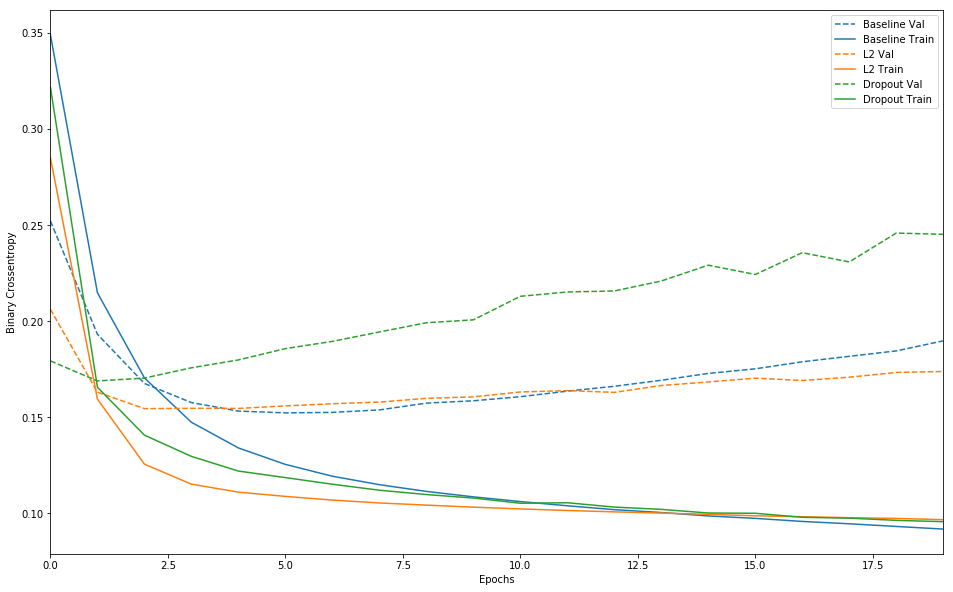

In [0]:
plot_history([('baseline', baseline_history),
              ('L2',l2_history),
              ('Dropout', dpt_history)
             ])

# Test Set evaluation
Your boss is now ready to look at your model. However, they want to evaluate your model on a separate test set before deploying it.
There's one small catch. It's possible that you've tuned your hyper-parameters a lot to lower the error on the validation set. Let's see if this affects you :-) 

**NOTE** We'll normilize the test set just as we did it for the training set.

In [0]:
! rm test*

rm: cannot remove 'test*': No such file or directory


In [0]:
# Original data belongs to https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data
! wget https://www.dropbox.com/s/tst2y6mzwzbhxo3/test.csv

--2019-10-22 02:43:17--  https://www.dropbox.com/s/tst2y6mzwzbhxo3/test.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.1, 2620:100:601f:1::a27d:901
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/tst2y6mzwzbhxo3/test.csv [following]
--2019-10-22 02:43:17--  https://www.dropbox.com/s/raw/tst2y6mzwzbhxo3/test.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc85429a225d9cb37af2ad0aecd5.dl.dropboxusercontent.com/cd/0/inline/Aq4XK0Pwoj3K83O3GU678EVday274yayRsFV0vZzD6uu0vq1oKcJBYmc4t7W5DsGY0m5qe9jAjzKjGUBz1yOoQWFILfpZvR-sZ6rEcLmbil7jg/file# [following]
--2019-10-22 02:43:17--  https://uc85429a225d9cb37af2ad0aecd5.dl.dropboxusercontent.com/cd/0/inline/Aq4XK0Pwoj3K83O3GU678EVday274yayRsFV0vZzD6uu0vq1oKcJBYmc4t7W5DsGY0m5qe9jAjzKjGUBz1yOoQWFILfpZvR-sZ6rEcLmbil7jg/file
Resolving uc85429a225d9cb37af2a

In [0]:
test_dataset = pd.read_csv("test.csv")[ ["comment_text", "toxic"] ]

In [0]:
# Print first values *before* normilization
test_dataset.head(5)

,comment_text,toxic
0,Thank you for understanding. I think very high...,0
1,:Dear god this site is horrible.,0
2,"""::: Somebody will invariably try to add Relig...",0
3,""" \n\n It says it right there that it IS a typ...",0
4,""" \n\n == Before adding a new product to the l...",0


In [0]:
### ---> Normize Test dataset
pd.options.mode.chained_assignment = None
norm_corpus = normalize_corpus(test_dataset['comment_text'])
test_dataset['comment_text'] = norm_corpus

In [0]:
# Print first values *after* normalization
test_dataset.head(5)


,comment_text,toxic
0,thank understanding think highly would revert ...,0
1,dear god site horrible,0
2,somebody invariably try add religion really me...,0
3,says right type type institution needed case t...,0
4,adding new product list make sure relevant add...,0


In [0]:
# convert Pandas Dataframe Series into Tensor Vector for evaluation
test_data = tf.data.Dataset.from_tensor_slices((test_dataset['comment_text'], test_dataset['toxic']))

In [0]:
results = base_model.evaluate(test_data.batch(512), verbose=2)
for name, value in zip(base_model.metrics_names, results):
  print("%s: %.3f" % (name, value))

125/125 - 1s - loss: 0.5184 - accuracy: 0.8787 - binary_crossentropy: 0.5183
loss: 0.518
accuracy: 0.879
binary_crossentropy: 0.518


In [0]:
results = l2_model.evaluate(test_data.batch(512), verbose=2)
for name, value in zip(l2_model.metrics_names, results):
  print("%s: %.3f" % (name, value))

125/125 - 1s - loss: 0.2814 - accuracy: 0.9058 - binary_crossentropy: 0.2754
loss: 0.281
accuracy: 0.906
binary_crossentropy: 0.275


In [0]:
results = dpt_model.evaluate(test_data.batch(512), verbose=2)
for name, value in zip(dpt_model.metrics_names, results):
  print("%s: %.3f" % (name, value))

125/125 - 1s - loss: 0.3474 - accuracy: 0.9060 - binary_crossentropy: 0.3474
loss: 0.347
accuracy: 0.906
binary_crossentropy: 0.347



## References

* Text classification using tf.keras https://www.tensorflow.org/tutorials/keras/basic_text_classification

* How to build a simple text classifier with TF-Hub https://www.tensorflow.org/tutorials/text_classification_with_tf_hub

* Text Classification Tutorial using Tensorflow: https://mohammadkhalifa.github.io/Step-by-Step-Text-Classification-Tutorial-using-Tensorflow/
  * Feature-engineering methods for text classification https://towardsdatascience.com/understanding-feature-engineering-part-3-traditional-methods-for-text-data-f6f7d70acd41


* Tensorflow Estimator API: https://www.tensorflow.org/tutorials/recurrent

* Using pre-trained word embeddings in a Keras model https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

* Text Classification with TensorFlow Estimators http://ruder.io/text-classification-tensorflow-estimators/

* Scikit-Learns NLP documentation: http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

* [Review on  Kaggle Toxic Comment Classification Challenge](https://medium.com/the-artificial-impostor/review-kaggle-toxic-comment-classification-challenge-part-1-934447339309)

* Text Classification in Google Cloud Platform, using Cloud ML Engine:
    * https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive/09_sequence/text_classification.ipynb
    * https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive/09_sequence/text_classification_native.ipynb
